# 배경색 분할

In [5]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# pip install scikit-image
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.data import astronaut
from skimage.util import img_as_float

# pip install PyMaxflow
import maxflow
from scipy.spatial import Delaunay



In [39]:
def superpixels_histgrams_neighbors(img) :
    segments = slic(img, n_segments=500, compactness = 20)
    segments_ids = np.unique(segments)
    
    
    centers = np.array([np.mean(np.nonzero(segments==i), axis=1) for i in segments_ids])
    
    
    hsv = cv.cvtColor(img.astype('float32'), cv.COLOR_BGR2HSV)
    bins = [20, 20]  # h,s = 20
    
    ranges = [0, 360, 0, 1]  # h [0~360], s[0,1]
    
    colors_hists = np.float32([cv.calcHist([hsv], [0,1], np.uint8(segments==i), bins, ranges).flatten() for i in segments_ids])
    
    tri = Delaunay(centers)
    
    return (centers, colors_hists, segments, tri.vertex_neighbor_vertices)

In [24]:
def find_superpixels_under_marking(marking, superpixels) :
    fg_segments = np.unique(superpixels[marking[:,:,0]!=255])
    bg_segments = np.unique(superpixels[marking[:,:,2]!=255])

    return (fg_segments, bg_segments)

In [8]:
def cumulative_histogram_for_superpixels(ids, histograms) :
    h = np.sum(histograms[ids], axis=0)
    return h/h.sum()

In [9]:
def pixels_for_segment_selection(superpixels_labels, selection) :
    pixels_mask = np.where(np.isin(superpixels_labels, selection), True, False)
    
    return pixels_mask

In [43]:
def normalize_histograms(histograms) :
    return np.float32([h/h.sum() for h in histograms])

In [11]:
def do_graph_cut(fgbg_hists, fgbg_superpixels, norm_hists, neighbors) :
    num_nodes = norm_hists.shape[0]
    
    g = maxflow.Graph[float](num_nodes, num_nodes*5)
    
    nodes = g.add_nodes(num_nodes)
    
    hist_comp_alg = cv.HISTCMP_KL_DIV
    
    indptr, indices = neighbors
    for i in range(len(indptr)-1) :
        N = indices[indptr[i]:indptr[i+1]]
        hi = norm_hists[i]
        for n in N :
            if (n < 0) or (n > num_nodes) :
                continue
            
            hn = norm_hists[n]
            g.add_edge(nodes[i], nodes[n], 20-cv.compareHist(hi, hn, hist_comp_alg),
                      20-cv.compareHist(hn, hi, hist_comp_alg))
    
    for i, h in enumerate(norm_hists) :
        if i in fgbg_superpixels[0] :
            g.add_tedge(nodes[i], 0, 1000) # FG- set high cost to BG
        elif i in fgbg_superpixels[1] :
            g.add_tedge(nodes[i], 1000, 0) # FG- set high cost to BG
        else :
            g.add_tedge(nodes[i], cv.compareHist(fgbg_hists[0], h, hist_comp_alg),
                       cv.compareHist(fgbg_hists[1], h, hist_comp_alg))
            
    g.maxflow()
    return g.get_grid_segments(nodes)

(600, 500, 3)
(600, 500)


Text(0.5, 1.0, 'origin')

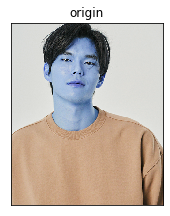

In [48]:

img_marking = cv.imread("img/clothes_test/08.jpg")
img = img_as_float(img_marking[::2, ::2])
print(img.shape)
# plt.imshow(img_marking)
# plt.show()
centers, colors_hists, segments, neighbors = superpixels_histgrams_neighbors(img)
print(segments.shape)
fg_segments, bg_segments = find_superpixels_under_marking(img_marking, segments)

fg_cumulative_hist = cumulative_histogram_for_superpixels(fg_segments, colors_hists)
bg_cumulative_hist = cumulative_histogram_for_superpixels(bg_segments, colors_hists)

norm_hists = normalize_histograms(colors_hists)

graph_cut = do_graph_cut((fg_cumulative_hist, bg_cumulative_hist),
                        (fg_segments, bg_segments),
                        norm_hists,
                        neighbors)

plt.subplot(1,2,2), plt.xticks([]), plt.yticks([])
plt.title("test")

segmask = pixels_for_segment_selection(segments, np.nonzero(graph_cut))
plt.imshow(segmask)

plt.imshow(img)
plt.title("origin")